In [1]:
from __future__ import print_function

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from tensorflow.keras import backend as K
# assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# Perform the search

In [4]:
costs = pd.read_csv("~/code/fifteen-puzzle/data/datasets/15-costs-v1.csv", nrows=6000000)
costs.shape

(6000000, 17)

In [5]:
costs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,cost
0,13,4,7,15,8,0,2,1,9,6,10,14,3,12,5,11,56
1,10,2,4,12,3,13,8,0,1,5,6,7,14,9,11,15,34
2,8,15,11,14,13,5,6,7,4,9,12,0,1,2,10,3,59
3,1,0,10,6,2,3,14,8,9,7,4,13,5,11,12,15,43
4,1,5,6,8,3,4,9,14,11,10,2,12,13,15,0,7,41


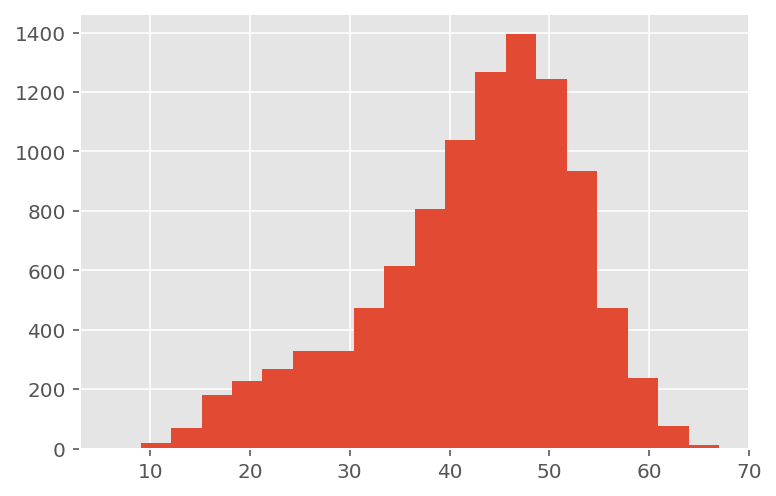

In [6]:
costs.sample(10000).cost.hist(bins=20);

In [7]:
X_raw = costs.iloc[:,:-1].values
y = costs['cost'].values

In [8]:
X = np.apply_along_axis(lambda x: np.eye(16)[x].ravel(), 1, X_raw)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 

In [10]:
del X, y

In [11]:
def asymmetric_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true) * K.square(K.sign(y_pred - y_true) + 0.4), axis=-1)

def get_model(layer_sizes, 
              learning_rate=0.001, 
              dropout_ratio=0.2, 
              activation='elu', 
              loss='mean_squared_error',
              kernel_initializer='he_normal', 
              batch_normalize=True,
              kernel_regularizer=None):
    model = Sequential()
    model.add(Dense(layer_sizes[0], 
                    input_shape=(256,), 
                    activation=activation, 
                    kernel_initializer=kernel_initializer,
                    kernel_regularizer=kernel_regularizer))
    model.add(Activation(activation))
    if batch_normalize:
        model.add(BatchNormalization())
    model.add(Dropout(dropout_ratio))
    
    for layer_size in layer_sizes[1:]:
        model.add(Dense(layer_size, 
                        activation=activation, 
                        kernel_initializer=kernel_initializer,
                        kernel_regularizer=kernel_regularizer))
        model.add(Activation(activation))
        if batch_normalize:
            model.add(BatchNormalization())
        model.add(Dropout(dropout_ratio))

    model.add(Dense(1, kernel_initializer='he_normal', kernel_regularizer=kernel_regularizer))
    model.compile(loss=loss,
                  optimizer=Adam(lr=learning_rate))
    return model

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=0, restore_best_weights=True)

model = get_model([1024, 512, 256, 128, 64], 
                  learning_rate=0.03, 
                  dropout_ratio=0.2,
                  loss=asymmetric_mean_squared_error)

history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 4800000 samples, validate on 1200000 samples
Epoch 1/10
4800000/4800000 [==============================] - 1297s 270us/sample - loss: 6.6478 - acc: 4.1667e-07 - val_loss: 2.8835 - val_acc: 0.0000e+00
Epoch 2/10
4800000/4800000 [==============================] - 1293s 269us/sample - loss: 3.9796 - acc: 4.1667e-07 - val_loss: 2.2703 - val_acc: 0.0000e+00
Epoch 3/10
4800000/4800000 [==============================] - 1305s 272us/sample - loss: 3.7060 - acc: 2.0833e-07 - val_loss: 2.5727 - val_acc: 0.0000e+00
Epoch 4/10
4800000/4800000 [==============================] - 1299s 271us/sample - loss: 3.4954 - acc: 4.1667e-07 - val_loss: 3.0727 - val_acc: 0.0000e+00
Epoch 5/10
4800000/4800000 [==============================] - 1298s 270us/sample - loss: 3.3694 - acc: 4.1667e-07 - val_loss: 2.0405 - val_acc: 0.0000e+00
Epoch 6/10
4800000/4800000 [==============================] - 1308s 273us/sample - loss: 3

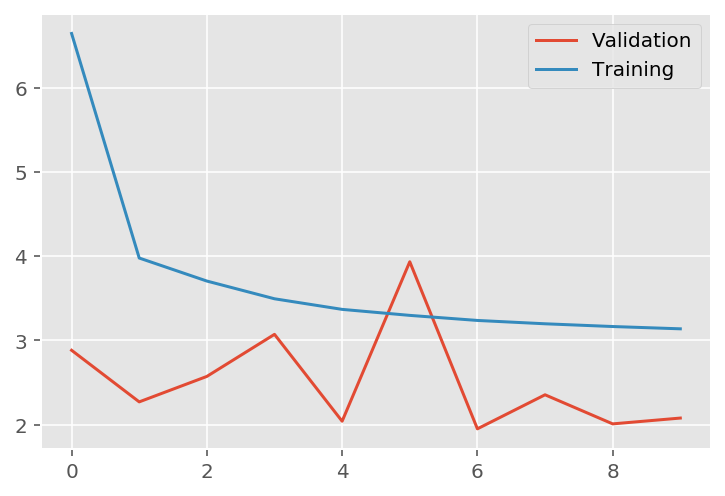

In [16]:
plt.plot(range(0, 10), history.history['val_loss'], label='Validation')
plt.plot(range(0, 10), history.history['loss'], label='Training')
plt.legend();

In [18]:
model.save('../../../data/neural-networks/keras-1024-512-256-128-64-amse04.h5')